# Finetuning Image2Text Models

Since there's a lot of pre-trained models already out there, for the most part you will likely only need to fine-tune them (or in many cases just use them out of the box). Fine-tuning is pretty straightforward and follows the normal ML training loop.

Note that we just demonstrate the loop here and aren't particularly concerned about things like accuracy for this example.

# Setup

In [1]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 5.9 MB/s eta 0:00:00


# Imports

In [2]:
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, BlipForConditionalGeneration

# Data

We use the modern-logo-dataset dataset because...it was the first small-ish dataset that popped up for me. And it fulfills the criteria we want - images and text. We restrict it to 32 images just to make things faster.

In [79]:
dataset = load_dataset("logo-wizard/modern-logo-dataset", split="train")
dataset = dataset.train_test_split(train_size=32)
train_data = dataset["train"]
test_data = dataset["test"]

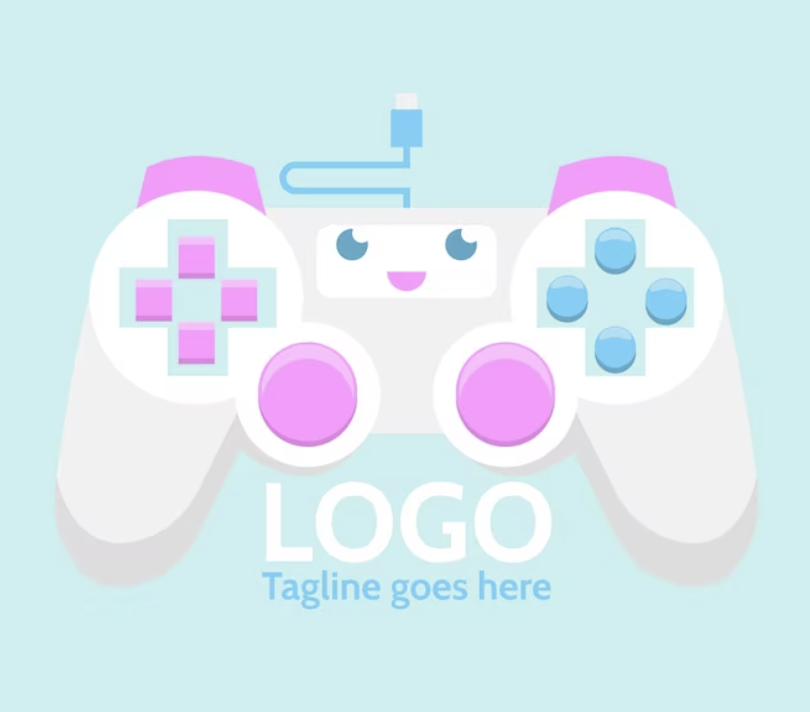

In [80]:
train_data[0]['image']

In [81]:
train_data[0]['text']

'"a logo of gamer store games with minimalistic gamepad, anime-style, with a wire and buttons, cartoon eyes and a smile on the gamepad, an inscription at the bottom, lavender background, whitesmoke, lavender foreground, minimalism, modern"'

In [82]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # processor adds a batch size - we just remove it here
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

# Model

We use blip-image-captioning-base. For production usecases, you might want to consider blip-image-captioning-large.

Pretty standard stuff here. The only thing that might look new is the processor. [Processors](https://huggingface.co/docs/transformers/main_classes/processors#processors) take care of handling multimodal data (image + text in our case) and are usually included alongside pretrained models.

In [83]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [84]:
train_dataset = ImageCaptioningDataset(train_data, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4)

# Training

In [85]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(20):
  print("Epoch:", epoch + 1)
  losses = []
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)
    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
  print("Loss:", torch.tensor(losses).mean())

Epoch: 1
Loss: tensor(10.2827)
Epoch: 2
Loss: tensor(7.8286)
Epoch: 3
Loss: tensor(6.1046)
Epoch: 4
Loss: tensor(4.3401)
Epoch: 5
Loss: tensor(2.7372)
Epoch: 6
Loss: tensor(1.8189)
Epoch: 7
Loss: tensor(1.5869)
Epoch: 8
Loss: tensor(1.5329)
Epoch: 9
Loss: tensor(1.5014)
Epoch: 10
Loss: tensor(1.4747)
Epoch: 11
Loss: tensor(1.4574)
Epoch: 12
Loss: tensor(1.4485)
Epoch: 13
Loss: tensor(1.4312)
Epoch: 14
Loss: tensor(1.4164)
Epoch: 15
Loss: tensor(1.4065)
Epoch: 16
Loss: tensor(1.3974)
Epoch: 17
Loss: tensor(1.3909)
Epoch: 18
Loss: tensor(1.3871)
Epoch: 19
Loss: tensor(1.3840)
Epoch: 20
Loss: tensor(1.3823)


# Inference

While we aren't really concerned with accuracy for this toy problem, it's nice to see how the model does with unseen data.

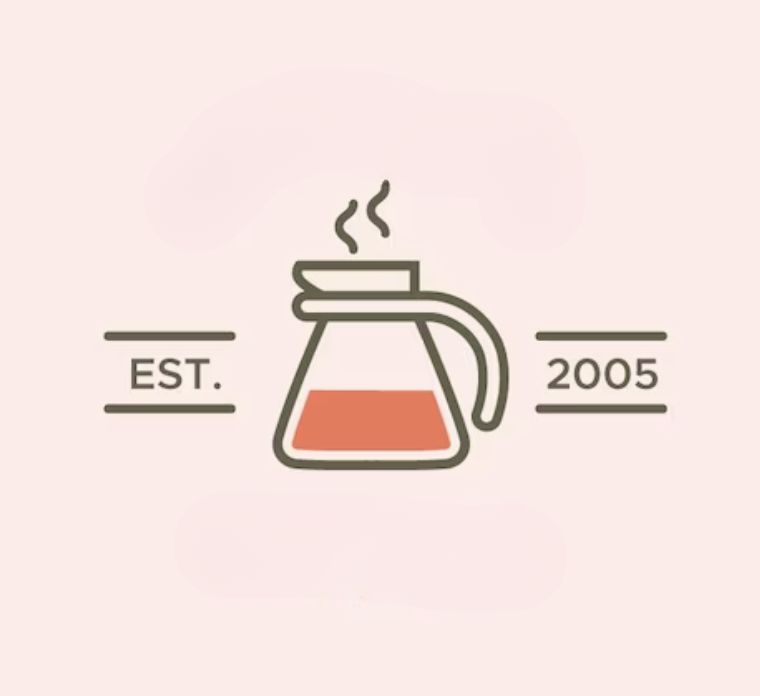

In [95]:
test_data[0]["image"]

In [96]:
test_data[0]["text"]

'"a logo of coffee shop, A mug in the form of a cola with a handle is depicted, linen background, darksalmon, dimgray foreground, minimalism, modern"'

In [97]:
sample = processor(images=test_data[0]["image"], return_tensors="pt").to(device)

generated_ids = model.generate(pixel_values=sample.pixel_values, max_length=100)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

" a logo of cafe restaurant bar with spoon and fork stylized like a branhces of plants, snow background, dimgray, darkgray foreground, minimalism, modern "
